In [1335]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

In [1336]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!mv /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c titanic

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat '/content/kaggle.json': No such file or directory
titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


## Extracting data

In [1337]:
zip_ref = zipfile.ZipFile("/content/titanic.zip")
zip_ref.extractall()
zip_ref.close()

In [1338]:
df_train = pd.read_csv("/content/train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot:>

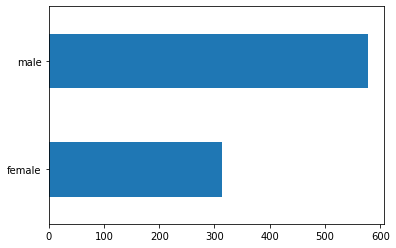

In [1339]:
df_train.Sex.value_counts().sort_values().plot(kind = 'barh')

In [1340]:
from typing import List
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

class EvaluateModel:
  def __init__(self, df):
    self.df_model = df

  def return_dataframe(self):
    return self.df_model

  def get_head(self):
    return self.df_model.head()

  def get_columns(self):
    return self.df_model.columns

  def get_unique(self, column):
    return self.df_model[column].unique()

  def plot_bar(self, column):
    self.df_model[column].value_counts().sort_values().plot(kind = "barh")
  
  def get_info(self):
    return self.df_model.info()
  
  def describe(self):
    return self.df_model.describe()

  def find_null_column(self) -> List:
    columns = self.df_model.columns[self.df_model.isnull().any()]
    return columns
  
  def fix_column(self, column:str , method: str):
    if method == "mean":
      self.df_model[column].fillna(self.df_model[column].mean(), inplace=True)

  def fix_column_str(self, column):
    self.df_model[column] = self.df_model[column].replace('', "0")

  def count_column_condition(self, column1, column2, condition):
    '''
      Count specific value in another column (column2) when we group by column2 
      given condition that aplies to column2

      Inputs:
        -column1: Column to group by
        -column2: Column in which we trying to count elements
        -condition: given condition to column2

      Returns:
        - List of columns and count of elements for them
    '''
    return df_train.groupby(column1)[column2].apply(lambda x: (x == condition).sum())

  def delete_columns(self, columns: List[str]):
    for i in columns:
      self.df_model = self.df_model.drop(i, axis=1)

  def get_dtypes(self):
    return self.df_model.dtypes

  def show_corr(self):
    plt.figure(figsize=(16,16))
    sns.heatmap(data=self.df_model.corr(), annot=True, fmt=".2f")

  def show_normal_distribution(self, columns):
    for i in columns:
      col = self.df_model[i]
      mean, std_dev = norm.fit(col)
      plt.figure(figsize=(10,10))
      plt.hist(col, bins=20, density=True, alpha=0.6, color='g')
      xmin, xmax = plt.xlim()
      x = np.linspace(xmin, xmax, 100)
      p = norm.pdf(x, mean, std_dev)
      plt.plot(x, p, 'k', linewidth=2)
      title = f"Normal distribution of {i}: mean = {mean:.2f}, std dev = {std_dev:.2f}"
      plt.title(title)
      plt.show()


  def dummies(self, columns):
    df = pd.get_dummies(self.df_model, columns = columns)
    self.df_model = df


  def min_max_scaler(self, columns):
    clf = MinMaxScaler()
    df_min_max = self.df_model[columns]
    data_transformed = clf.fit_transform(df_min_max.to_numpy())
    data_transformed = pd.DataFrame(data_transformed)
    df_one_hot = pd.concat([self.df_model.drop(columns, axis=1), data_transformed], axis=1)
    self.df_model = pd.DataFrame(df_one_hot)




In [1341]:
def preparing_data(df):
  df = EvaluateModel(df)
  df.fix_column("Age", "mean")
  df.fix_column_str("Cabin")
  df.delete_columns(["PassengerId", "Name", "Ticket"])
  df_help = df.return_dataframe()
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^C\d+', 'Second')
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^E\d+', 'Third')
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^B\d+', 'First')
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^F\d+', 'Third')
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^A\d+', 'First')
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^D\d+', 'Third')
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^G\d+', 'Third')
  df_help['Cabin'] = np.where((df_help['Cabin'] != 'First') & (df_help['Cabin'] != 'Second'), 'Third', df_help['Cabin'])
  df_help['Age'] = df_help['Age'].apply(lambda x: 'children' if x < 10 else ("Teen" if x < 20 else ("Adult" if x < 50 else "Elder")))

  df_help['SibSp'] = df_help['SibSp'].apply(lambda x: 'low' if x < 3 else "high")
  df_help['Parch'] = df_help['Parch'].apply(lambda x: 'parched' if x < 4 else "not_parched")
  df_help['Fare'] = df_help['Fare'].apply(lambda x: 'low' if x < 30 else "high")
  df = EvaluateModel(df_help)
  df.dummies(["Sex","Cabin","Age","Embarked","SibSp", "Parch", "Fare","Pclass"])
  df_train = df.return_dataframe()
  return df_train

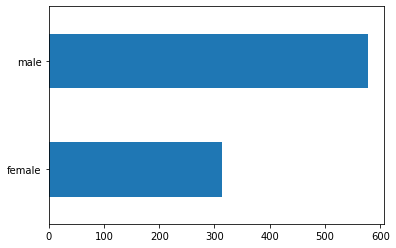

In [1342]:
df = EvaluateModel(df_train)
df.plot_bar("Sex")

In [1343]:
df.get_columns()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [1344]:
df.get_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [1345]:
df.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [1346]:
df.find_null_column()


Index(['Age', 'Cabin', 'Embarked'], dtype='object')

In [1347]:
df.get_dtypes()

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [1348]:
df.count_column_condition("Fare", "Survived", 0)

Fare
0.0000      14
4.0125       1
5.0000       1
6.2375       1
6.4375       1
            ..
227.5250     1
247.5208     1
262.3750     0
263.0000     2
512.3292     0
Name: Survived, Length: 248, dtype: int64

In [1349]:
df.count_column_condition("Fare", "Survived", 1)

Fare
0.0000      1
4.0125      0
5.0000      0
6.2375      0
6.4375      0
           ..
227.5250    3
247.5208    1
262.3750    2
263.0000    2
512.3292    3
Name: Survived, Length: 248, dtype: int64

In [1350]:
df.get_columns()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [1351]:
df.get_head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1352]:
df = df_test = pd.read_csv("/content/train.csv")
df = preparing_data(df)
X = df.drop("Survived", axis=1)
y = df["Survived"]

<ipython-input-1341-439fa54d15f8>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^C\d+', 'Second')
<ipython-input-1341-439fa54d15f8>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^E\d+', 'Third')
<ipython-input-1341-439fa54d15f8>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^B\d+', 'First')
<ipython-input-1341-439fa54d15f8>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^F\d+', 'Third')
<ipython-input-1341-439fa54d15f8>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^A\d+', 'First

In [1353]:
df

,Survived,Sex_female,Sex_male,Cabin_First,Cabin_Second,Cabin_Third,Age_Adult,Age_Elder,Age_Teen,Age_children,...,Embarked_S,SibSp_high,SibSp_low,Parch_not_parched,Parch_parched,Fare_high,Fare_low,Pclass_1,Pclass_2,Pclass_3
0,0,0,1,0,0,1,1,0,0,0,...,1,0,1,0,1,0,1,0,0,1
1,1,1,0,0,1,0,1,0,0,0,...,0,0,1,0,1,1,0,1,0,0
2,1,1,0,0,0,1,1,0,0,0,...,1,0,1,0,1,0,1,0,0,1
3,1,1,0,0,1,0,1,0,0,0,...,1,0,1,0,1,1,0,1,0,0
4,0,0,1,0,0,1,1,0,0,0,...,1,0,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,1,0,0,1,1,0,0,0,...,1,0,1,0,1,0,1,0,1,0
887,1,1,0,1,0,0,0,0,1,0,...,1,0,1,0,1,1,0,1,0,0
888,0,1,0,0,0,1,1,0,0,0,...,1,0,1,0,1,0,1,0,0,1
889,1,0,1,0,1,0,1,0,0,0,...,0,0,1,0,1,1,0,1,0,0


## Models to consider 
1. SGD Classifier
2. Linear SVC
3. DeepLearning

### Preparing data

In [1354]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix



## Model_0 SGD Classifier

In [1355]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=39)
clf.fit(X, y)

SGDClassifier(random_state=39)

In [1356]:
model_0_acc = clf.score(X,y)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


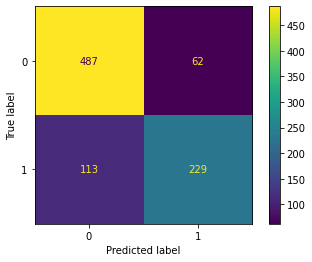

In [1357]:
plot_confusion_matrix(clf, X, y)

## Model 1: Linear SVC

In [1358]:
from sklearn.svm import LinearSVC
clf_svc = LinearSVC(random_state=0, tol=1e-5)
clf_svc.fit(X,y)

LinearSVC(random_state=0, tol=1e-05)

In [1359]:
model_1_acc = clf_svc.score(X,y)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


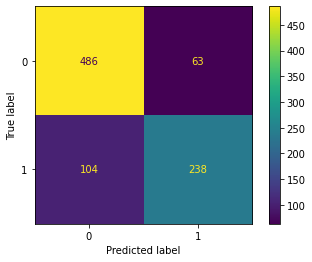

In [1360]:
plot_confusion_matrix(clf_svc, X, y)

## Model 3: DeepLearning

In [1361]:
def plot_history(history):
  '''
  Takes history of our model and plot accuracy and loss function

  parms:
  history - model history

  output:
  -
  '''
  loss = history.history["loss"]
  acc = history.history["accuracy"]
  number_of_elements = len(loss)
  epochs = np.linspace(1,number_of_elements,number_of_elements)

  ## Plotting functions
  fig,ax = plt.subplots(2,1, figsize=(10,7))
  ax[0].plot(epochs, acc)
  ax[0].set_title("Accuracy")  
  ax[1].plot(epochs, loss)
  ax[1].set_title("Loss function")
  plt.show()

In [1362]:
import tensorflow as tf
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1363]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1,"sigmoid")
])

model_3.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                metrics=["accuracy"])
history_3 = model_3.fit(X_train,
                        y_train,
                        validation_data=(X_test, y_test),
                        epochs=10,
                        verbose=0)

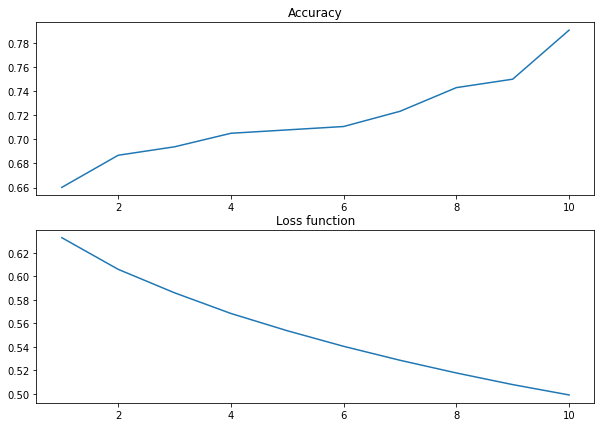

In [1364]:
plot_history(history_3)

In [1365]:
model_acc_3 = model_3.evaluate(X, y)
model_acc_3

28/28 [==============================] - 0s 2ms/step - loss: 0.4923 - accuracy: 0.7946


[0.4923059642314911, 0.7946127653121948]

28/28 [==============================] - 0s 2ms/step


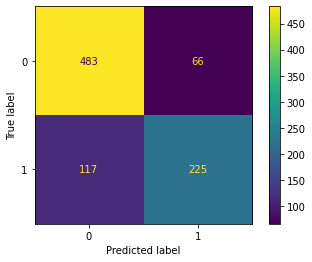

In [1366]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pred = tf.squeeze(tf.round(model_3.predict(X)))

confusion_matrix = confusion_matrix(y, pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

### Updating models solutions

In [1367]:
# df_sub.to_csv('data.csv', index=False)
# from google.colab import files
# files.download('data.csv')

### Simple model base on fact that most women survived and all children

In [1372]:
df_test = pd.read_csv("/content/train.csv")
df = preparing_data(df_test)
X = df.drop("Survived", axis=1)
y = df["Survived"]

<ipython-input-1341-439fa54d15f8>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^C\d+', 'Second')
<ipython-input-1341-439fa54d15f8>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^E\d+', 'Third')
<ipython-input-1341-439fa54d15f8>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^B\d+', 'First')
<ipython-input-1341-439fa54d15f8>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^F\d+', 'Third')
<ipython-input-1341-439fa54d15f8>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^A\d+', 'First

In [1373]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1,"sigmoid")
])

model_4.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                metrics=["accuracy"])
history_4 = model_4.fit(X_train,y_train,epochs=10,validation_data=(X_test, y_test),verbose=0)

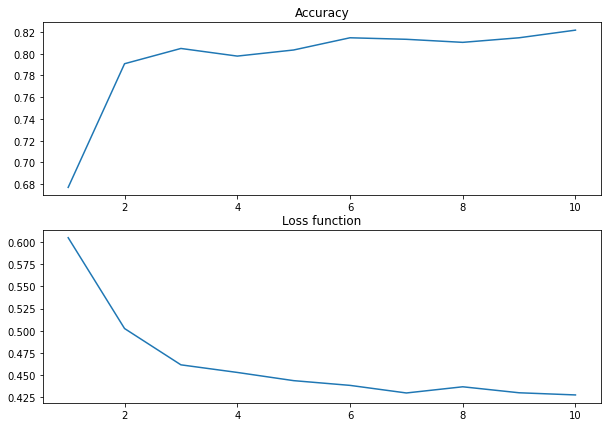

In [1322]:
plot_history(history_4)

In [1323]:
model_acc_4 = model_4.evaluate(X, y)
model_acc_4[1]

28/28 [==============================] - 0s 3ms/step - loss: 0.4316 - accuracy: 0.8148


0.8148148059844971

28/28 [==============================] - 0s 2ms/step


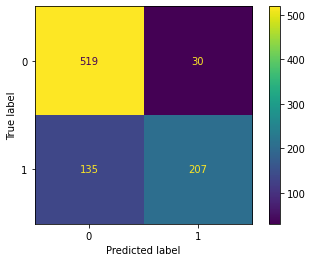

In [1324]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pred = tf.squeeze(tf.round(model_4.predict(X)))

confusion_matrix = confusion_matrix(y, pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

## Trying to build better model with:
1. SVM
2. RandomForestClassifier

## SVM

In [1374]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1,0.2,0.3,0.5,0.7,0.9, 1,2,5,7, 10,25,50,70, 100],
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              'gamma': ['scale', 'auto']}

clf_svm = svm.SVC()
grid_search = GridSearchCV(clf_svm, param_grid, cv=5)
grid_search.fit(X, y)
# clf_svm.fit(X, y)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1, 2, 5, 7, 10, 25,
                               50, 70, 100],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']})

In [1375]:
model_5_acc = grid_search.score(X,y)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


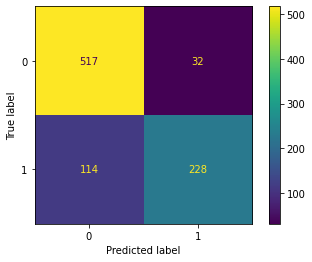

In [1376]:
# clf.score(X,y)
plot_confusion_matrix(grid_search, X, y)

## RandomForestClassifier

In [1328]:
from sklearn.ensemble import RandomForestClassifier
clf_rfc = RandomForestClassifier(n_estimators=5)
clf_rfc = clf.fit(X, y)

In [1329]:
model_6_acc = clf_rfc.score(X,y)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


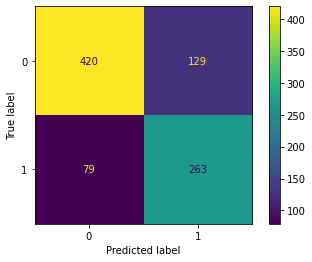

In [1330]:
plot_confusion_matrix(clf_rfc, X, y)

In [1331]:
concluion = pd.DataFrame(data={"SGD Classifier":model_0_acc, "Linear SVC":model_1_acc, "DL_1_M3":model_acc_3, "DL_2_M4":model_acc_4, "SVM":model_5_acc, "RandomForestClassifier":model_6_acc })
conclusion.transpose()

,0,1
SGD Classifier,0.712682,0.712682
Linear SVC,0.810325,0.810325
DL_1_M3,0.467981,0.785634
DL_2_M4,0.401452,0.832772
SVM,0.827160,0.827160
RandomForestClassifier,0.712682,0.712682


In [1382]:
df_test = pd.read_csv("/content/test.csv")
df = preparing_data(df_test)
X = df

df_sub = pd.read_csv("/content/gender_submission.csv")

preds = grid_search.predict(X)
df_sub["Survived"]=preds

<ipython-input-1341-439fa54d15f8>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^C\d+', 'Second')
<ipython-input-1341-439fa54d15f8>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^E\d+', 'Third')
<ipython-input-1341-439fa54d15f8>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^B\d+', 'First')
<ipython-input-1341-439fa54d15f8>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^F\d+', 'Third')
<ipython-input-1341-439fa54d15f8>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^A\d+', 'First

In [1383]:
df_sub

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [1384]:
df_sub.to_csv('data.csv', index=False)
from google.colab import files
files.download('data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>